# Treinamento do modelo com Pycaret

## Importando as bibliotecas necessárias

In [1]:
import pandas as pd
from pycaret.classification import *
import matplotlib.pyplot as plt
import missingno as msno

### Importando as bibliotecas necessárias para Autenticação no Google Drive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ModuleNotFoundError: No module named 'google.colab'

## Importando o dataset já pré-processado

In [5]:
file_id = '1kZbSMhVR01__CCVPJAjt0FAyEN5s9J2h'
file_name = 'dados_agregados.csv'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_name)

### Definindo os targets para o AutoML

In [6]:
data = pd.read_csv(file_name)
target = 'message0418DAA1'
other_target = 'message0422DAA1'

### Verificando o número de linhas e colunas do dataset.

In [7]:
data.shape

(595350, 66)

### Identificando os tipos de dados, quantos são falso e quantos são verdadeiros.

In [8]:
data[target].value_counts()

0.0    594619
1.0       299
Name: message0418DAA1, dtype: int64

### Retirando colunas que não serão utilizadas e linhas nulas e verificando na matriz, se existe se está "faltando" algum valor em todo o dataset.

In [9]:
data = data.dropna()

In [10]:
data = data.drop(other_target, axis=1)

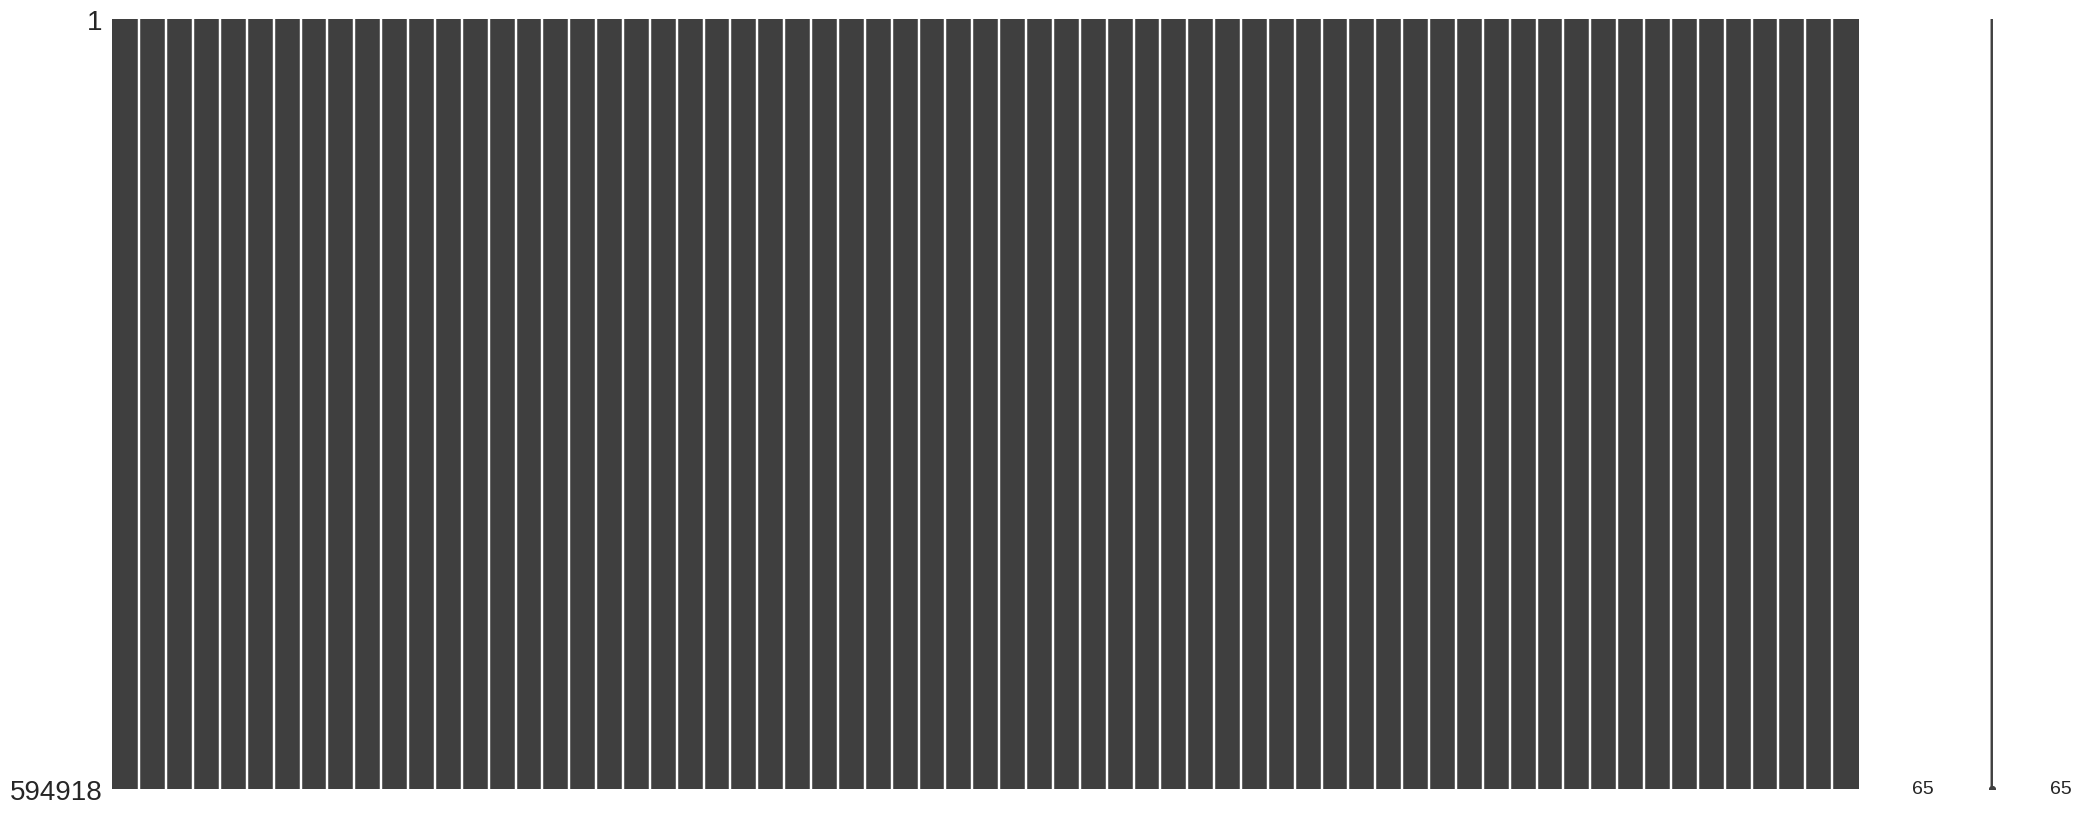

<Figure size 2500x2500 with 0 Axes>

In [11]:
msno.matrix(data)
plt.figure(figsize=(25,25))
plt.show()

In [12]:
data[target].value_counts()

0.0    594619
1.0       299
Name: message0418DAA1, dtype: int64

## Balanceamento das classes

### Undersampling dos dados - Diminui o número de exemplos da classe majoritária, que no caso o nosso dataset é a classe 0 do nosso target.

In [13]:
from imblearn.under_sampling import RandomUnderSampler

X = data.drop(target, axis=1)
y = data[target]

rus = RandomUnderSampler(random_state=42, sampling_strategy=0.03)
X_res, y_res = rus.fit_resample(X, y)

data = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res, columns=[target])], axis=1)

In [14]:
data[target].value_counts()

0.0    9966
1.0     299
Name: message0418DAA1, dtype: int64

### Oversampling dos dados - Aumenta o número de exemplos da classe minoritária, que no caso o nosso dataset é a classe 1 do nosso target.

In [15]:
from imblearn.over_sampling import SMOTE

X = data.drop(target, axis=1)
y = data[target]

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

data = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res, columns=[target])], axis=1)

In [ ]:
data[target].value_counts()

## Inicialização do ambiente de treinamento e realização de várias tarefas de pré-processamento automaticamente.

In [16]:
clf1 = setup(data, target=target)

,Description,Value
0,Session id,394
1,Target,message0418DAA1
2,Target type,Binary
3,Original data shape,"(19932, 65)"
4,Transformed data shape,"(19932, 65)"
5,Transformed train set shape,"(13952, 65)"
6,Transformed test set shape,"(5980, 65)"
7,Numeric features,64
8,Preprocess,True
9,Imputation type,simple


## Comparação de modelos

In [17]:
best_model = compare_models(fold=10)
best_model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9994,0.9999,1.0000,0.9987,0.9994,0.9987,0.9987,0.7350
lightgbm,Light Gradient Boosting Machine,0.9990,1.0000,0.9994,0.9986,0.9990,0.9980,0.9980,3.1790
rf,Random Forest Classifier,0.9989,0.9999,0.9996,0.9983,0.9989,0.9978,0.9979,2.7990
xgboost,Extreme Gradient Boosting,0.9988,0.9999,0.9996,0.9980,0.9988,0.9976,0.9976,4.2470
dt,Decision Tree Classifier,0.9971,0.9971,0.9983,0.9960,0.9971,0.9943,0.9943,0.2310
gbc,Gradient Boosting Classifier,0.9966,0.9999,0.9994,0.9937,0.9966,0.9931,0.9931,7.3030
ada,Ada Boost Classifier,0.9962,0.9997,0.9991,0.9933,0.9962,0.9924,0.9924,3.9840
knn,K Neighbors Classifier,0.9860,0.9946,0.9980,0.9747,0.9862,0.9720,0.9723,0.3620
lda,Linear Discriminant Analysis,0.9693,0.9907,0.9847,0.9553,0.9697,0.9385,0.9390,0.3890
ridge,Ridge Classifier,0.9690,0.0000,0.9860,0.9536,0.9695,0.9379,0.9385,0.1230


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=394, verbose=0, warm_start=False)

## Visualização de métricas

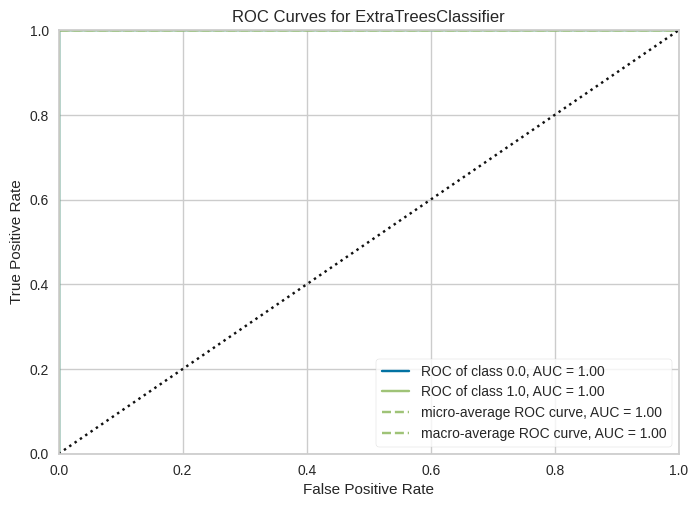

In [18]:
plot_model(best_model, plot="auc")

### Matrix de confusão

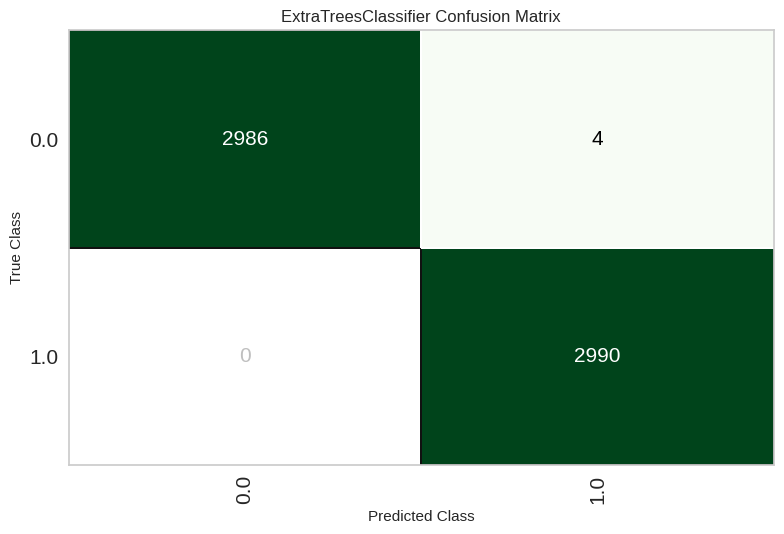

In [19]:
plot_model(best_model, plot = 'confusion_matrix')

## Otimização de hipermarâmetros

In [20]:
# Hyperparameter tuning
tuned_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9692,0.9967,0.9885,0.9517,0.9698,0.9384,0.9391
1,0.9771,0.9972,0.9943,0.9612,0.9775,0.9542,0.9547
2,0.9799,0.9975,0.9986,0.9627,0.9803,0.9599,0.9605
3,0.9778,0.9982,0.9871,0.9690,0.9780,0.9556,0.9557
4,0.9778,0.9978,0.9928,0.9638,0.9781,0.9556,0.9560
5,0.9713,0.9968,0.9914,0.9531,0.9719,0.9427,0.9434
6,0.9699,0.9974,0.9914,0.9505,0.9705,0.9398,0.9407
7,0.9821,0.9984,0.9986,0.9667,0.9824,0.9642,0.9647
8,0.9735,0.9968,0.9943,0.9546,0.9740,0.9470,0.9478


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


## Avaliação do modelo

In [21]:
# Evaluate the model
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Treinamento do modelo com os dados completos (treino e teste)

In [22]:
final_model = finalize_model(tuned_model)

## Testando o modelo nos dados iniciais novamente

In [23]:
data_original = pd.read_csv('dados_agregados.csv')
data_original = data_original.dropna()
predictions = predict_model(final_model, data=data_original)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9986,1.0000,1.0000,0.2689,0.4238,0.4234,0.5182


## Salvando o modelo

In [25]:
save_model(final_model, '/content/final_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['aircraftSerNum1',
                                              'amscChBasHealthStatus1',
                                              'amscChBasHealthStatus2',
                                              'amscHprsovDrivF1',
                                              'amscHprsovDrivF2',
                                              'amscPrsovDrivF1',
                                              'amscPrsovDrivF2',
                                              'basBleedLowPressF1',
                                              'basBleedLowPressF2',
                                              'basBleedLowTempF1',
                                              'basBleedLowTempF2',
                                              'basBleedOverPressF...
                  ExtraTreesClassifier(bootstrap=False, ccp_

### Criação da API em FastAPI integrado com o modelo.

In [ ]:
create_api(melhor_modelo, 'minha_api')